  # Metrics for decisional impact


  ### Installation

  <pre>pip install pandas pingouin seaborn matplotlib sklearn</pre>

  We need the development version of scikit-posthocs to get critical difference diagrams

  <pre>pip install git+https://github.com/maximtrp/scikit-posthocs.git</pre>



In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pingouin as pg
import scikit_posthocs as sp
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, precision_score, recall_score, confusion_matrix
from statsmodels.stats.multicomp import MultiComparison
from scipy.stats import levene
from statsmodels.stats.anova import AnovaRM
import copy
import matplotlib.ticker as mtick

  A few utility functions to make life easier

In [2]:
def plot_binned(df, thresholds_exp, thresholds_pred):
    # Ensure thresholds start with -np.inf and end with np.inf
    if thresholds_exp[0] > -np.inf:
        thresholds_exp.insert(0, -np.inf)
    if thresholds_exp[-1] < np.inf:
        thresholds_exp.append(np.inf)

    if thresholds_pred[0] > -np.inf:
        thresholds_pred.insert(0, -np.inf)
    if thresholds_pred[-1] < np.inf:
        thresholds_pred.append(np.inf)

    labels_exp = [f'{round(thresholds_exp[i], 2)}-{round(thresholds_exp[i+1], 2)}' for i in range(len(thresholds_exp)-1)]
    labels_pred = [f'{round(thresholds_pred[i], 2)}-{round(thresholds_pred[i+1], 2)}' for i in range(len(thresholds_pred)-1)]

    df = df.dropna(subset=['Sol', 'Sol_pred'], how='any')

    df['Sol_bin'] = pd.cut(df['Sol'], bins=thresholds_exp, labels=labels_exp)
    df['Sol_pred_bin'] = pd.cut(df['Sol_pred'], bins=thresholds_pred, labels=labels_pred)

    df['Sol_bin'] = df['Sol_bin'].astype('category')
    df['Sol_pred_bin'] = df['Sol_pred_bin'].astype('category')

    cross_tab = pd.crosstab(df['Sol_pred_bin'], df['Sol_bin'])
    cross_tab_percent = cross_tab.div(cross_tab.sum(axis=1), axis=0)
    ax = cross_tab_percent.plot(kind='bar', stacked=True, figsize=(10, 8))

    # Add percentages on the regions
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.text(x+width/2, 
                y+height/2, 
                '{:.0f} %'.format(height*100), 
                horizontalalignment='center', 
                verticalalignment='center')

    # Add counts at the top of each bar
    counts = cross_tab.sum(axis=1)
    for i, count in enumerate(counts):
        ax.text(i, 1, str(count), ha='center', va='bottom', color='black', fontsize=14)

    plt.xlabel('Predicted Solubility Bin')
    plt.ylabel('Percentage')
    plt.title('Stacked Bar Chart of Predicted vs Actual Solubility Bins')
    plt.show()
    
def recall_at_precision(y_true, y_score, precision_threshold=0.5, direction='greater'):
    if direction not in ['greater', 'lesser']:
        raise ValueError("Invalid direction. Expected one of: ['greater', 'lesser']")

    y_true = np.array(y_true)
    y_score = np.array(y_score)
    thresholds = np.unique(y_score)
    thresholds = np.sort(thresholds)

    if direction == 'greater':
        thresholds = np.sort(thresholds)
    else:  
        thresholds = np.sort(thresholds)[::-1]

    for threshold in thresholds:
        if direction == 'greater':
            y_pred = y_score >= threshold
        else:  
            y_pred = y_score <= threshold

        precision = precision_score(y_true, y_pred)
        if precision >= precision_threshold:
            recall = recall_score(y_true, y_pred)
            return recall, threshold

    return np.nan, None

def plot_binned_one_panel(df, thresholds_exp, thresholds_pred, ax=None, method = ""):

    thresholds_pred_tmp = copy.deepcopy(thresholds_pred)

    # Ensure thresholds start with -np.inf and end with np.inf
    if thresholds_exp[0] > -np.inf:
        thresholds_exp.insert(0, -np.inf)
    if thresholds_exp[-1] < np.inf:
        thresholds_exp.append(np.inf)

    if thresholds_pred_tmp[0] > -np.inf:
        thresholds_pred_tmp.insert(0, -np.inf)
    if thresholds_pred_tmp[-1] < np.inf:
        thresholds_pred_tmp.append(np.inf)

    labels_exp = [f'{round(thresholds_exp[i], 2)}-{round(thresholds_exp[i+1], 2)}' for i in range(len(thresholds_exp)-1)]
    labels_pred = [f'{round(thresholds_pred_tmp[i], 2)}-{round(thresholds_pred_tmp[i+1], 2)}' for i in range(len(thresholds_pred_tmp)-1)]

    df = df.dropna(subset=['Sol', 'Sol_pred'], how='any')

    df['Sol_bin'] = pd.cut(df['Sol'], bins=thresholds_exp, labels=labels_exp)
    df['Sol_pred_bin'] = pd.cut(df['Sol_pred'], bins=thresholds_pred_tmp, labels=labels_pred)

    df['Sol_bin'] = df['Sol_bin'].astype('category')
    df['Sol_pred_bin'] = df['Sol_pred_bin'].astype('category')

    cross_tab = pd.crosstab(df['Sol_pred_bin'], df['Sol_bin'])
    cross_tab_percent = cross_tab.div(cross_tab.sum(axis=1), axis=0)
    cross_tab_percent.plot(kind='bar', stacked=True, ax=ax)

    # Add percentages on the regions
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.text(x+width/2, 
                y+height/2, 
                '{:.0f} %'.format(height*100), 
                horizontalalignment='center', 
                verticalalignment='center')

    # Add counts at the top of each bar
    counts = cross_tab.sum(axis=1)
    for i, count in enumerate(counts):
        ax.text(i, 1, str(count), ha='center', va='bottom', color='black', fontsize=14)

    ax.set_xlabel('Predicted Solubility Bin')
    ax.set_ylabel('Percentage')
    ax.set_title(f'{method} Predicted vs Actual Solubility Bins')

def plot_binned_grid(df, thresholds_exp):
    methods = df['method'].unique()
    fig, axs = plt.subplots(1, len(methods), figsize=(15, 5))

    thresh_all = {}
    recall_all = {}

    for ax, method in zip(axs, methods):
        df_method = df[df['method'] == method]
        recall_neg, thresh_neg = recall_at_precision(df_method['Sol_neg'], df_method['Sol_pred'], precision_threshold=0.8, direction='lesser')
        recall_pos, thresh_pos = recall_at_precision(df_method['Sol_pos'], df_method['Sol_pred'], precision_threshold=0.8, direction='greater')
        thresh_ls = [thresh_neg, thresh_pos]
        if thresh_neg > thresh_pos:
            thresh_ls = [thresh_pos]
        plot_binned_one_panel(df_method, thresholds_exp, thresh_ls, ax, method)
        thresh_all[method] = thresh_ls
        recall_all[method] = [recall_neg, recall_pos]

    plt.tight_layout()
    plt.show()

    return thresh_all, recall_all

def make_scatterplot(df, method, thresholds, ax):
    df_method = df[df['method'] == method]
    
    ax.scatter(df_method['Sol_pred'], df_method['Sol'], alpha=0.3)
    ax.plot([df_method['Sol'].min(), df_method['Sol'].max()], 
             [df_method['Sol'].min(), df_method['Sol'].max()], 'k--', lw=1)

    for thresh in thresholds:
        ax.axhline(y=thresh, color='r', linestyle='--')
        ax.axvline(x=thresh, color='r', linestyle='--')

    ax.set_title(method)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Measured')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: '{:g}'.format(x)))
    ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: '{:g}'.format(x)))

def make_scatterplot_grid(df, thresholds):
    methods = df['method'].unique()
    fig, axs = plt.subplots(1, len(methods), figsize=(8 * len(methods), 8))
    
    for ax, method in zip(axs, methods):
        make_scatterplot(df, method, thresholds[method], ax)
    
    plt.tight_layout()
    plt.show()

  ### 1. Read in data


In [3]:
df_input = pd.read_csv("Sol_regression_ChemProp_LightGBM.csv")
df_input = df_input[df_input["cv_cycle"] == 0] # Extract only one split

df_scaffold = df_input.query("split == 'scaffold'").copy()
df_scaffold['log_Sol'] = df_scaffold['Sol']
df_scaffold['log_Sol_pred'] = df_scaffold['Sol_pred']
df_scaffold['Sol'] = 10**df_scaffold['Sol']
df_scaffold['Sol_pred'] = 10**df_scaffold['Sol_pred']
df_scaffold.head()

,cv_cycle,split,method,SMILES,Name,Sol,Sol_pred,log_Sol,log_Sol_pred
21800,0,scaffold,chemprop_st,CC(C)n1cc(-c2ccc3c(c2)N(C)CC3)c2c(NS(=O)(=O)c3...,Mol428,43.078958,84.598972,1.634265,1.927365
21801,0,scaffold,chemprop_st,Oc1cccc(CN2CCN(c3ncc(Br)cn3)CC2)c1,Mol1693,14.173959,100.242168,1.151491,2.001050
21802,0,scaffold,chemprop_st,Fc1cccc(CN2CCN(c3ncccn3)CC2)c1,Mol883,139.538129,120.862271,2.144693,2.082291
21803,0,scaffold,chemprop_st,Fc1ccccc1CN1CCN(c2ncccn2)CC1,Mol549,132.928428,106.653149,2.123618,2.027974
21804,0,scaffold,chemprop_st,O=C(O)c1nc(-c2ccccc2)oc1-c1ccccc1,Mol919,153.806716,30.039282,2.186975,1.477690


## 2. Deriving the metric

We would like to use the solubility model to apply two types of filters: 1) a what to make filter and 2) a what NOT to make filter.

- For filter 1, we would like to be confident that everything left after filtering will measure high solubility.  Chemists would like to make selections within this set and be confident the compounds are soluble. We would like the set of confident positives left to be as large as possible. A larger set of compounds provides the chemists with more options.   
- For filter 2, we would like to be confident that everything filtered out will measure low solubility. We would like to eliminate a large number of bad compounds without eliminating many positives.

We consider anything with >100uM to be positive solubility for filter 1 and anything with <10uM to be negative solubilty for filter 2.  You could set the threshold to be the same for positive and negatives to keep things simpler, but we demonstrate the case when there are different thresholds.  You would be required to keep the threshold the same for a binary classification model.

The first plot shows the performance of the model when the experimental thresholds and predicted thresholds are the same. We can see that in this case the confirmation probabilities for positives and negatives (also known as PPV and NPV) is 76%.

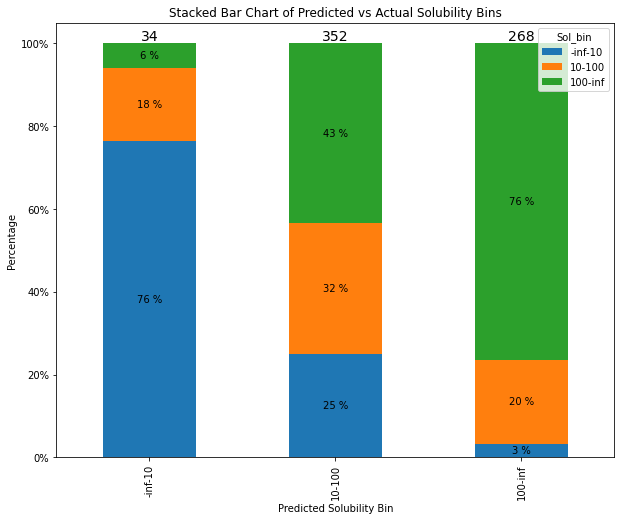

In [4]:
target_thresh = [10, 100]
plot_binned(df_scaffold, target_thresh, target_thresh)

Now lets say we require the positive and negative confirmation probabilities to be >80%.  We can tune the predicted thresholds so that 1) the confirmation probabilties meet this constraint and 2) the sets of confident positives and negatives are as large as possible.

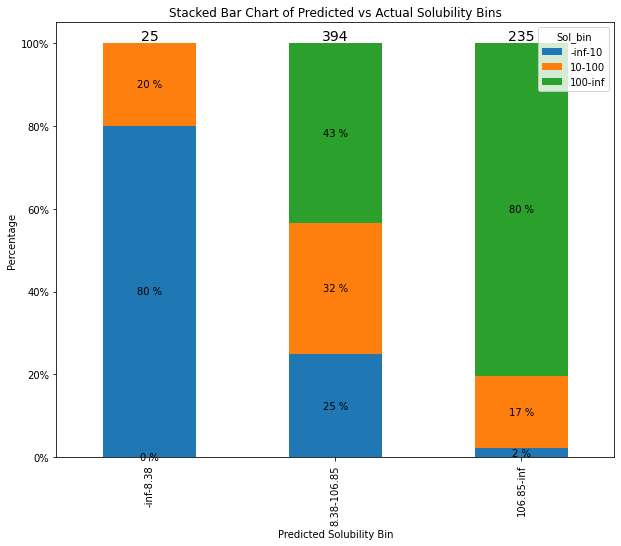

In [5]:
# Targeting <10uM for negative solublity and >100uM for positive solubility
df_scaffold['Sol_neg'] = (df_scaffold['Sol'] < 10).astype(int)
df_scaffold['Sol_pos'] = (df_scaffold['Sol'] > 100).astype(int)

recall_neg, thresh_neg = recall_at_precision(df_scaffold['Sol_neg'], df_scaffold['Sol_pred'], precision_threshold=0.8, direction='lesser')
recall_pos, thresh_pos = recall_at_precision(df_scaffold['Sol_pos'], df_scaffold['Sol_pred'], precision_threshold=0.8, direction='greater')
plot_binned(df_scaffold, [10, 100], [thresh_neg, thresh_pos])

## 3. Comparing the methods

Now lets compare performance of the three modeling methods. We tune the thresholds separately for each method.  We would like the methods to be able to perform both filter 1 and filter 2, so we prefer methods with the fewest compounds in the center bin.

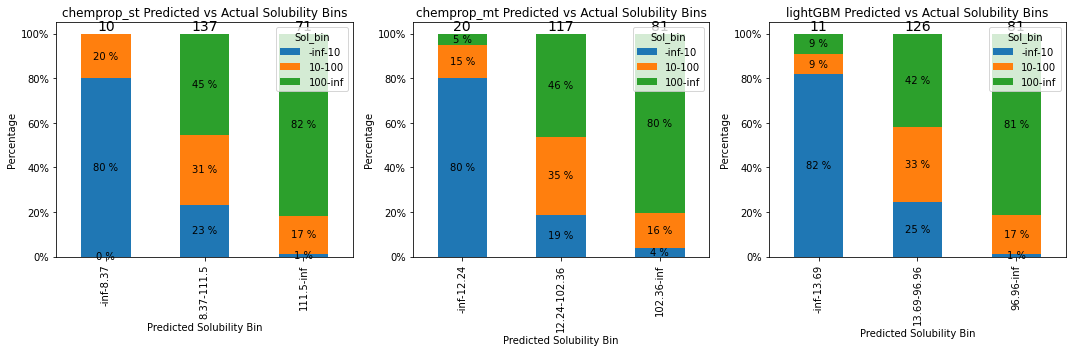

In [6]:
thresh_all, recall_all = plot_binned_grid(df_scaffold, [10, 100])

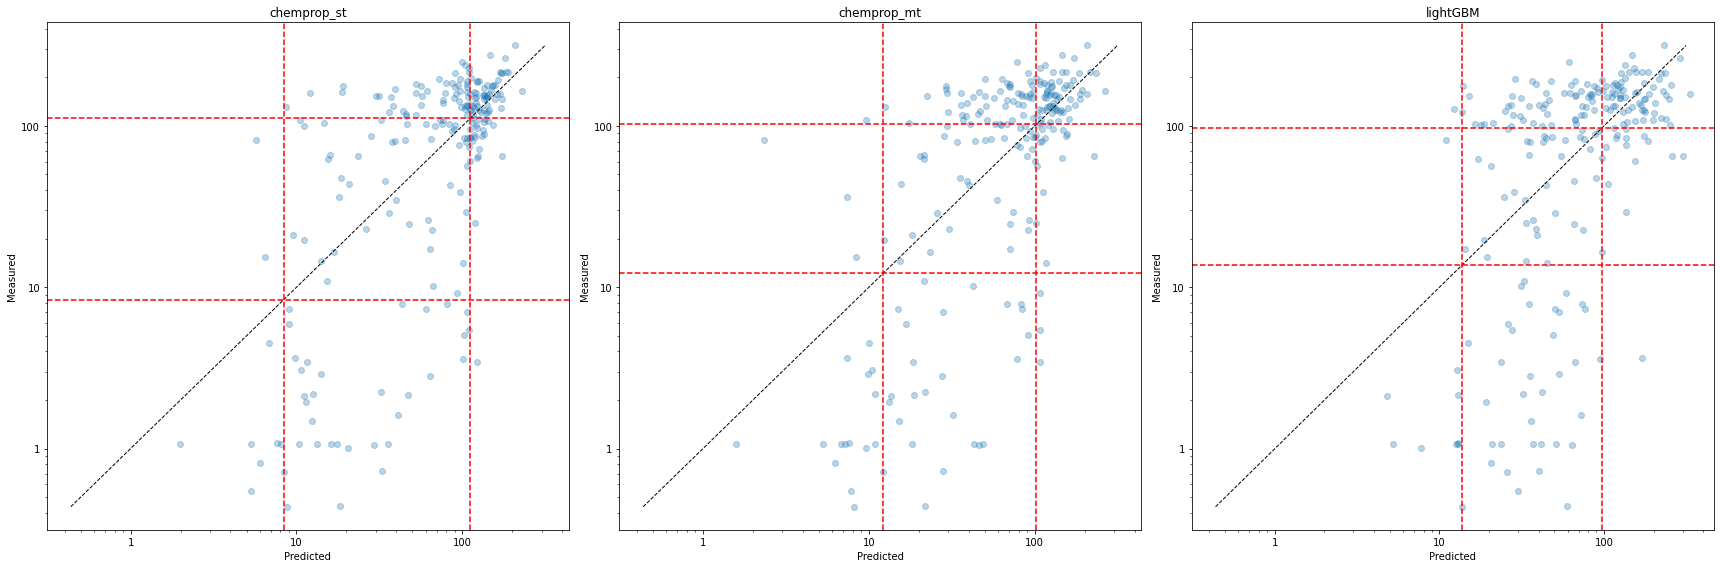

In [7]:
make_scatterplot_grid(df_scaffold, thresh_all)

The metrics that can be used for statistical testing are shown below. For filter 1, we use the positive class recall at the tuned threshold. This is the fraction of positive compounds that were retained after the filter. For filter 2, we use the negative class recall at the tuned threshold.  This is the fraction of negative compounds that will be eliminated by filter 2.

In [8]:
perf_df = pd.DataFrame(recall_all)
perf_df.index = ['recall_neg', 'recall_pos']
perf_df

,chemprop_st,chemprop_mt,lightGBM
recall_neg,0.195122,0.390244,0.219512
recall_pos,0.483333,0.550000,0.550000


## 4. Conclusions

When there are small differences in global metrics like MAE and R2 it is difficult to determine if this will translate to a meaningful difference when models are used in practice.

The metrics shown here provide a way to measure decisional impact by looking at two ways ADME models are often used in practice.  There are other metrics one could use, but I think it is useful to provide an example of measuring decisional impact in a way that others can use. This will tie into our discussions of effect size and practical significance.

The metrics can also be used for a classification model.  Often people report small differences in AUROC or AUPRC, and it is difficult to determine if these are meaningful. When used for classification models, these two metrics would highlight relevant regions on the ROC and PR curves to help modelers decide if the differences are meaningful. I will provide an example of this soon.